In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/dev-achintha/Sri_Lanka-Tourism_Forcasting_Model/prophet/dataset/2014-2024-monthly-tourist-arrivals-sl-csv.csv')
df = df.drop(columns=['PercentageChange'], errors='ignore')
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')
df.rename(columns={'Arrivals': 'y'}, inplace=True)
df = df[['ds', 'y']]
df.head()

,ds,y
0,2014-01-01,146575
1,2014-02-01,141878
2,2014-03-01,133048
3,2014-04-01,112631
4,2014-05-01,90046


In [2]:
# Split data into train and test sets
train = df[:-24]
test = df[-24:]

In [3]:
#prophet
from prophet import Prophet

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,
                        changepoint_prior_scale=0.1, n_changepoints=30)
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# changepoints = ['2019-04-21', '2020-03-01', '2022-03-22', '2023-02-25']
#     # 2019-04-21 Easter Bombings
#     # 2020-03-01 Covid19 Pandemic
#     # 2022-03-22 Dollar rate increses
#     # 2023-02-25 Dollar rate decreases
# model = Prophet(changepoints=changepoints)

model_prophet.fit(train)

future_prophet = model_prophet.make_future_dataframe(periods=24, freq='ME')
forecast_prophet = model_prophet.predict(future_prophet)

06:00:26 - cmdstanpy - INFO - Chain [1] start processing
06:00:26 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(steps=24)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02766D+01    |proj g|=  1.24216D-01

At iterate    5    f=  1.02438D+01    |proj g|=  5.17627D-02

At iterate   10    f=  1.02372D+01    |proj g|=  1.26834D-03

At iterate   15    f=  1.02372D+01    |proj g|=  4.09548D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   1.564D-05   1.024D+01
  F =   10.237194792619087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [5]:
# LSTM Model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['y']])

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

seq_length = 12
X = create_sequences(scaled_data[:-1], seq_length)
y = scaled_data[seq_length:-1]  # Adjust y to have the same number of samples as X

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=100, batch_size=32, verbose=0)

last_sequence = scaled_data[-seq_length:]
forecast_lstm = []

for _ in range(24):
    next_pred = model_lstm.predict(last_sequence.reshape(1, seq_length, 1))
    forecast_lstm.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

forecast_lstm = scaler.inverse_transform(np.array(forecast_lstm).reshape(-1, 1))

2024-10-16 06:00:37.674733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 06:00:37.678098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 06:00:37.687433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 06:00:37.701333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 06:00:37.705542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 06:00:37.719201: I tensorflow/core/platform/cpu_feature_gu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [10]:
import warnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress the ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define and fit the Exponential Smoothing model
model_es = ExponentialSmoothing(train['y'], seasonal_periods=12, trend='add', seasonal='add')
results_es = model_es.fit(optimized=True, remove_bias=True)

# Forecast using the fitted model
forecast_es = results_es.forecast(24)

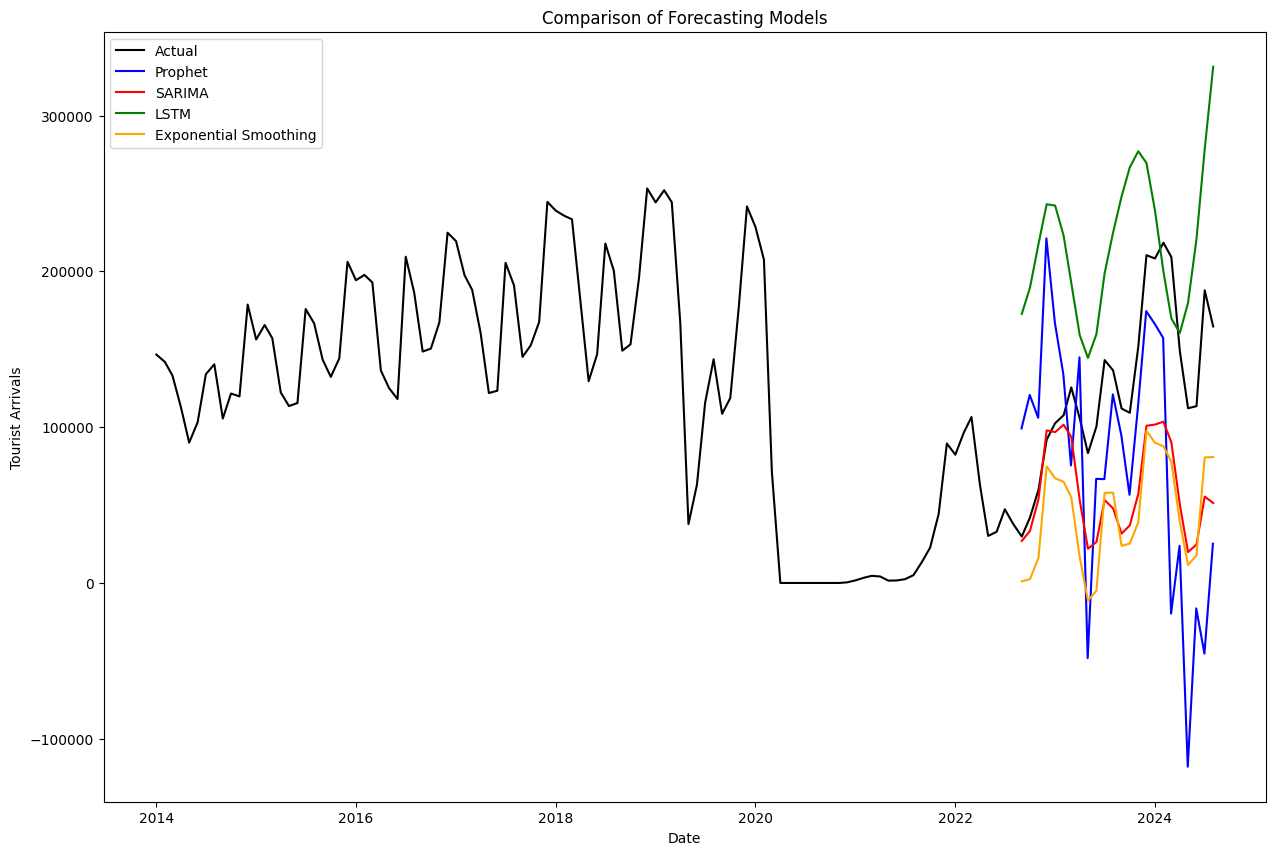

In [11]:
# Plotting
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(df['ds'], df['y'], label='Actual', color='black')
plt.plot(forecast_prophet['ds'][-24:], forecast_prophet['yhat'][-24:], label='Prophet', color='blue')
plt.plot(test['ds'], forecast_sarima, label='SARIMA', color='red')
plt.plot(test['ds'], forecast_lstm, label='LSTM', color='green')
plt.plot(test['ds'], forecast_es, label='Exponential Smoothing', color='orange')
plt.title('Comparison of Forecasting Models')
plt.xlabel('Date')
plt.ylabel('Tourist Arrivals')
plt.legend()
plt.show()

In [12]:
# Calculate MAE for each model
from sklearn.metrics import mean_absolute_error


mae_prophet = mean_absolute_error(test['y'], forecast_prophet['yhat'][-24:])
mae_sarima = mean_absolute_error(test['y'], forecast_sarima)
mae_lstm = mean_absolute_error(test['y'], forecast_lstm)
mae_es = mean_absolute_error(test['y'], forecast_es)

print(f"MAE Prophet: {mae_prophet}")
print(f"MAE SARIMA: {mae_sarima}")
print(f"MAE LSTM: {mae_lstm}")
print(f"MAE Exponential Smoothing: {mae_es}")


MAE Prophet: 87229.15375560976
MAE SARIMA: 68969.09074247057
MAE LSTM: 93762.59440104167
MAE Exponential Smoothing: 83541.2909200419


In [1]:
# !sudo apt-get update
# !sudo apt-get install -y pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic
# %pip install jupyter_core jupyter platformdirs pypandoc
!jupyter nbconvert --to pdf /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_TourismForecastModel_Prophet.ipynb

[NbConvertApp] Converting notebook /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_TourismForecastModel_Prophet.ipynb to pdf
[NbConvertApp] Support files will be in Sri_Lankan_TourismForecastModel_Prophet_files/
[NbConvertApp] Making directory ./Sri_Lankan_TourismForecastModel_Prophet_files
[NbConvertApp] Writing 43850 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 133766 bytes to /workspaces/Sri_Lanka-Tourism_Forcasting_Model_SARIMA/notebooks/Sri_Lankan_TourismForecastModel_Prophet.pdf
